# Bayesian Regression in Pyro: GDP and Terrain Ruggedness

The following simple bayesian regression example is adapted from \[1\]. We will use the dataset from \[2\], replicate the authors' central point in the paper (see abstract below), and use this to motivate different ways of doing bayesian regression in Pyro - i.e. approximate inference via Stochastic Variational Inference and exact inference via Hamiltonian Monte Carlo.


> We show that geography, through its impact on history, can have important effects on current economic development. The analysis focuses on the historic interaction between ruggedness and Africa's slave trades. Although rugged terrain hinders trade and most productive activities, negatively affecting income globally, within Africa rugged terrain afforded protection to those being raided during the slave trades. Since the slave trades retarded subsequent economic development, within Africa ruggedness has also had a historic indirect positive effect on income. Studying all countries worldwide, we estimate the differential effect of ruggedness on income for Africa. We show that the differential effect of ruggedness is statistically significant and economically meaningful, it is found in Africa only, it cannot be explained by other factors like Africa's unique geographic environment, and it is fully accounted for by the history of the slave trades.


  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012

In [105]:
from __future__ import absolute_import, division, print_function

import argparse
from functools import partial
import logging
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import pyro
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO
from pyro.infer.abstract_infer import TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

In [44]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
pyro.set_rng_seed(1)
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"

### Dataset 

We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP. In particular, it was noted by the authors in \[2\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a net positive effect on income for African nations due to the historical protection from raiding due to slave trade. Let us look at the dataset and plot this relationship.

In [45]:
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [46]:
rugged_data.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


[Text(0,0.5,'log GDP (2000)'),
 Text(0.5,0,'terrain ruggedness index'),
 Text(0.5,1,'African Nations')]

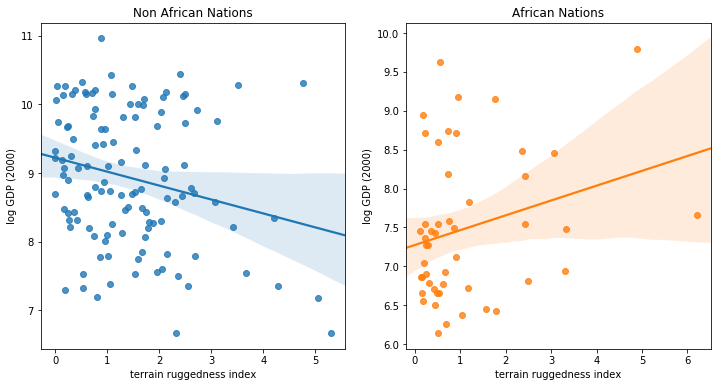

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
african_nations = rugged_data[rugged_data["cont_africa"] == 1]
non_african_nations = rugged_data[rugged_data["cont_africa"] == 0]
sns.regplot(non_african_nations["rugged"], 
            np.log(non_african_nations["rgdppc_2000"]), 
            ax=ax[0])
ax[0].set(xlabel="terrain ruggedness index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.regplot(african_nations["rugged"], 
            np.log(african_nations["rgdppc_2000"]), 
            ax=ax[1])
ax[1].set(xlabel="terrain ruggedness index",
          ylabel="log GDP (2000)",
          title="African Nations")

Let us try to use bayesian linear regression to see if we can capture and quantify this relationship. We will be regressing log GDP in 2000 w.r.t. only two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index. Note that, additionally, we need an interaction feature to capture this observed reversal. 

In [48]:
def train_test_split(pd_dataframe):
    df = pd_dataframe[["cont_africa", "rugged", "rgdppc_2000"]]
    df = df[np.isfinite(df.rgdppc_2000)]
    data = torch.tensor(df.values, dtype=torch.float)
    data[:, 2] = data[:, 2].log()
    num_train = int(len(data) * 0.8)
    train, test = torch.split(data[torch.randperm(len(data))], num_train)
    return train, test

In [111]:
def summary(traces, sites):
    marginal = EmpiricalMarginal(traces, sites).get_samples_and_weights()[0].detach().cpu().numpy()
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [50]:
train, test = train_test_split(rugged_data)
N_TRAIN, N_TEST = len(train), len(test)

In [51]:
def model(is_cont_africa, ruggedness):
    a = pyro.sample("a", dist.Normal(8., 1000.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mu = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.iarange("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mu, sigma))

In [52]:
def conditioned_model(log_gdp, *args, **kwargs):
    return poutine.condition(model, data={"obs": log_gdp})(*args, **kwargs)

In [53]:
train, test = train_test_split(rugged_data)

### SVI with a Diagonal Normal Guide

In [54]:
guide = AutoDiagonalNormal(conditioned_model)
svi = SVI(conditioned_model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(10000):
    elbo = svi.step(log_gdp, is_cont_africa, ruggedness)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 451.7452955842018
Elbo loss: 473.7116972208023
Elbo loss: 415.69265389442444
Elbo loss: 428.5286649465561
Elbo loss: 401.30916237831116
Elbo loss: 382.7052810192108
Elbo loss: 409.05527544021606
Elbo loss: 293.2189407348633
Elbo loss: 259.18585163354874
Elbo loss: 246.67305308580399
Elbo loss: 224.6169589161873
Elbo loss: 216.57312935590744
Elbo loss: 209.9820750951767
Elbo loss: 209.90357357263565
Elbo loss: 208.05178081989288
Elbo loss: 207.39181685447693
Elbo loss: 207.96871399879456
Elbo loss: 206.24380987882614
Elbo loss: 206.63163381814957
Elbo loss: 208.44611245393753


In [55]:
svi_diagnorm_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

In [112]:
sites = ["a", "bA", "bR", "bAR"]

for site, values in summary(svi_diagnorm_posterior, sites).items():
    print(site)
    print(values, "\n")

a
       mean       std        5%      25%       50%       75%       95%
0  9.114936  0.085967  8.982929  9.05175  9.113273  9.172086  9.259281 

bA
       mean       std        5%       25%       50%      75%      95%
0 -1.651164  0.152682 -1.901802 -1.750568 -1.650697 -1.55074 -1.41173 

bR
       mean       std        5%       25%       50%       75%       95%
0 -0.126918  0.044111 -0.201546 -0.155213 -0.128367 -0.096739 -0.054629 

bAR
       mean       std        5%       25%       50%       75%      95%
0  0.250415  0.084801  0.108149  0.193021  0.250988  0.307025  0.39253 



### Exact Inference using HMC

In [57]:
nuts_kernel = NUTS(conditioned_model, adapt_step_size=True)

hmc_posterior = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200) \
    .run(log_gdp, is_cont_africa, ruggedness)

INFO 	 Starting MCMC using kernel - NUTS ...
INFO 	 Iteration: 60 [WARMUP]
INFO 	 Step size: 0.031245 	 Acceptance rate: 0.883333
INFO 	 Iteration: 120 [WARMUP]
INFO 	 Step size: 0.054631 	 Acceptance rate: 0.883333
INFO 	 Iteration: 180 [WARMUP]
INFO 	 Step size: 0.043413 	 Acceptance rate: 0.877778
INFO 	 Iteration: 240 [SAMPLE]
INFO 	 Step size: 0.043495 	 Acceptance rate: 0.900000
INFO 	 Iteration: 300 [SAMPLE]
INFO 	 Step size: 0.043495 	 Acceptance rate: 0.906667
INFO 	 Iteration: 360 [SAMPLE]
INFO 	 Step size: 0.043495 	 Acceptance rate: 0.916667
INFO 	 Iteration: 420 [SAMPLE]
INFO 	 Step size: 0.043495 	 Acceptance rate: 0.928571
INFO 	 Iteration: 480 [SAMPLE]
INFO 	 Step size: 0.043495 	 Acceptance rate: 0.937500
INFO 	 Iteration: 540 [SAMPLE]
INFO 	 Step size: 0.043495 	 Acceptance rate: 0.944444
INFO 	 Iteration: 600 [SAMPLE]
INFO 	 Step size: 0.043495 	 Acceptance rate: 0.946667
INFO 	 Iteration: 660 [SAMPLE]
INFO 	 Step size: 0.043495 	 Acceptance rate: 0.950000
INFO 	 Ite

In [58]:
sites = ["a", "bA", "bR", "bAR"]

for site, values in summary(hmc_posterior, sites).items():
    print(site)
    print(values, "\n")

a
       mean       std       25%      50%       75%
0  9.124084  0.167518  9.020303  9.11801  9.233488 

bA
       mean       std       25%       50%       75%
0 -1.657947  0.253834 -1.820773 -1.645017 -1.487756 

bR
       mean       std       25%       50%       75%
0 -0.114219  0.089263 -0.172711 -0.116639 -0.055974 

bAR
       mean       std      25%       50%       75%
0  0.250467  0.140056  0.15646  0.246097  0.344771 



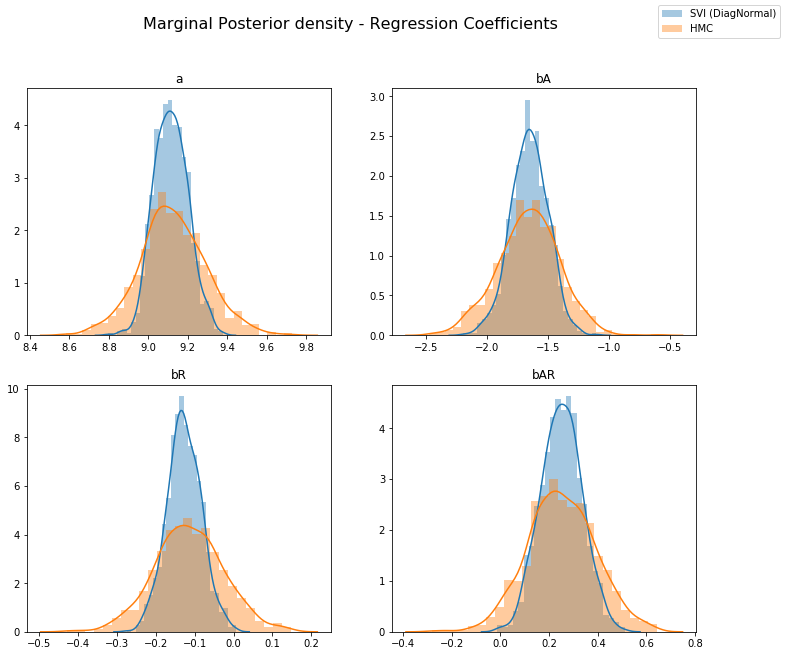

In [59]:
svi_diagnorm_empirical = EmpiricalMarginal(svi_diagnorm_posterior, sites=sites) \
                         .get_samples_and_weights()[0] \
                         .detach().cpu().numpy()
hmc_empirical = EmpiricalMarginal(hmc_posterior, sites=sites).get_samples_and_weights()[0].numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_diagnorm_empirical[:, i], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
    ax.set_title(sites[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

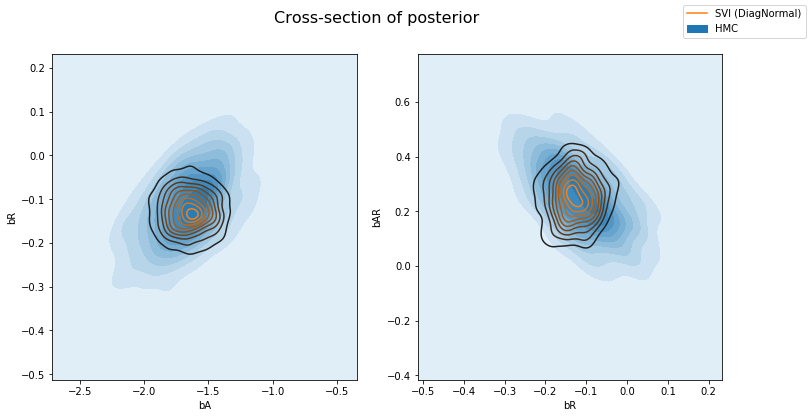

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of posterior", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 1], svi_diagnorm_empirical[:, 2], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR")
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 2], svi_diagnorm_empirical[:, 3], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR")
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

### Comparison with SVI using Multivariate Normal Guide

In [61]:
guide = AutoMultivariateNormal(conditioned_model)
svi = SVI(conditioned_model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(10000):
    elbo = svi.step(log_gdp, is_cont_africa, ruggedness)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 619.90680372715
Elbo loss: 533.9421651363373
Elbo loss: 438.93544602394104
Elbo loss: 448.03427612781525
Elbo loss: 439.7798751592636
Elbo loss: 339.8986728191376
Elbo loss: 331.9086846113205
Elbo loss: 403.4365648031235
Elbo loss: 280.76709616184235
Elbo loss: 317.9036237001419
Elbo loss: 313.8227449655533
Elbo loss: 299.4347311258316
Elbo loss: 253.52992409467697
Elbo loss: 203.6481335759163
Elbo loss: 211.0648283958435
Elbo loss: 204.94071125984192
Elbo loss: 210.12182199954987
Elbo loss: 208.67272198200226
Elbo loss: 210.19124919176102
Elbo loss: 206.8747457265854


In [62]:
svi_mvn_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

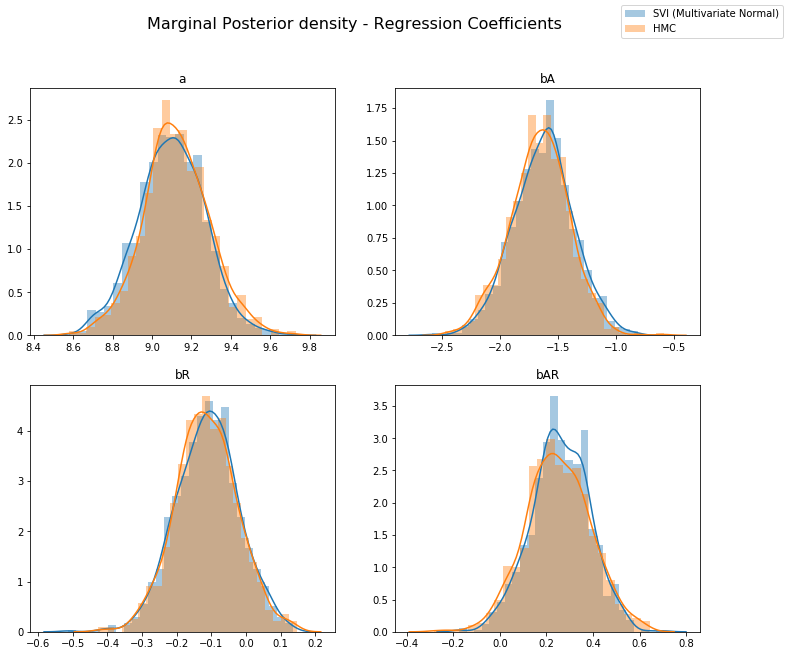

In [63]:
svi_mvn_empirical = EmpiricalMarginal(svi_mvn_posterior, sites=sites).get_samples_and_weights()[0] \
                    .detach().cpu().numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_mvn_empirical[:, i], ax=ax, label="SVI (Multivariate Normal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
    ax.set_title(sites[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

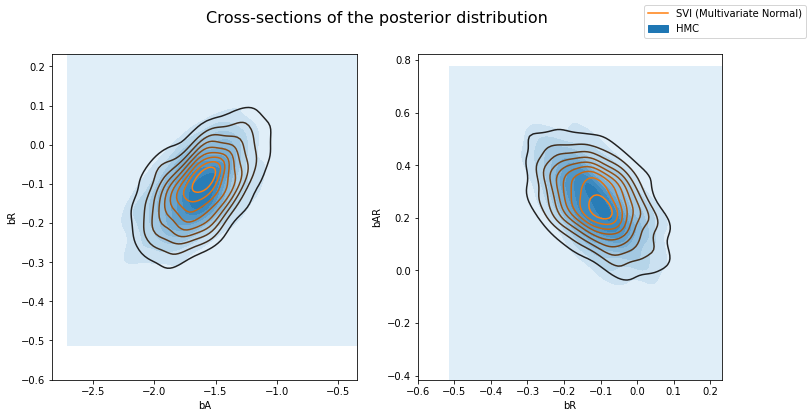

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the posterior distribution", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 1], svi_mvn_empirical[:, 2], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR")
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_mvn_empirical[:, 2], svi_mvn_empirical[:, 3], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR")
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

### Slope of Log GDP vs. Terrain Ruggedness 

Text(0.5,0.98,'Density of Slope : log(GDP) vs. terrain ruggedness')

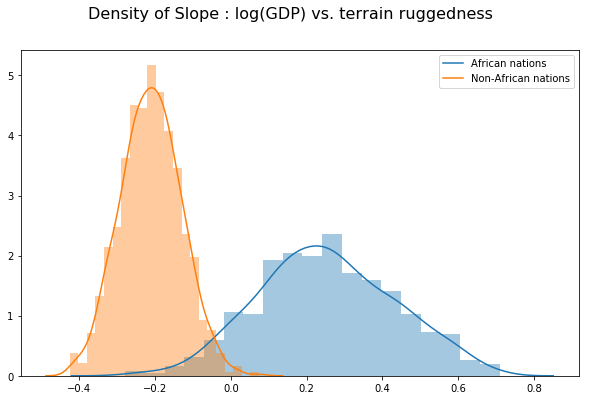

In [140]:
gamma_within_africa = hmc_empirical[:, 2] + empirical[:, 3]
gamma_outside_africa = hmc_empirical[:, 2]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. terrain ruggedness", fontsize=16)

### Model Predictions

[Text(0,0.5,'log GDP (2000)'),
 Text(0.5,0,'terrain ruggedness index'),
 Text(0.5,1,'African Nations')]

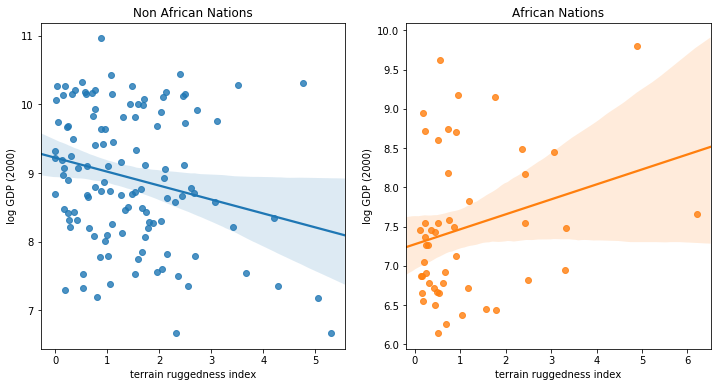

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
african_nations = rugged_data[rugged_data["cont_africa"] == 1]
non_african_nations = rugged_data[rugged_data["cont_africa"] == 0]
sns.regplot(non_african_nations["rugged"], 
            np.log(non_african_nations["rgdppc_2000"]), 
            ax=ax[0])
ax[0].set(xlabel="terrain ruggedness index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.regplot(african_nations["rugged"], 
            np.log(african_nations["rgdppc_2000"]), 
            ax=ax[1])
ax[1].set(xlabel="terrain ruggedness index",
          ylabel="log GDP (2000)",
          title="African Nations")

In [77]:
def evaluate_log_predictive_density(model_trace_posterior, model_name):
    is_cont_africa, ruggedness, log_gdp = test[:, 0], test[:, 1], test[:, 2]
    test_eval = TracePredictive(conditioned_model,
                                model_trace_posterior,
                                num_samples=1000)
    test_eval.run(log_gdp, is_cont_africa, ruggedness)
    trace_log_pdf = []
    for tr in test_eval.exec_traces:
        trace_log_pdf.append(tr.log_prob_sum())
    # Use LogSumExp trick to evaluate $log(1/num_samples \sum_i p(new_data | \theta^{i})) $,
    # where $\theta^{i}$ are parameter samples from the model's posterior.
    posterior_pred_density = logsumexp(torch.stack(trace_log_pdf), dim=-1) - math.log(len(trace_log_pdf))
    logging.info("\nLog posterior predictive density: {}".format(model_name))
    logging.info("---------------------------------")
    logging.info("{:.4f}\n".format(posterior_pred_density))

In [75]:
evaluate_log_predictive_density(hmc_posterior, "HMC")
evaluate_log_predictive_density(svi_diagnorm_posterior, "SVI (DiagNormal)")
evaluate_log_predictive_density(svi_mvn_posterior, "SVI (Multivariate Normal)")


Log posterior predictive density: HMC
---------------------------------
-25.7364


Log posterior predictive density: SVI (DiagNormal)
---------------------------------
-25.6268


Log posterior predictive density: SVI (Multivariate Normal)
---------------------------------
-25.7186



In [78]:
svi_diagnorm_posterior.exec_traces[700].log_prob_sum()

tensor(-201.4028)

In [116]:
trace_pred = TracePredictive(model,
                             hmc_posterior,
                             num_samples=1000)
post_pred = trace_pred.run(is_cont_africa, ruggedness)
predictions = summary(post_pred, sites=["obs"])["obs"]
predictions = pd.DataFrame({
    "cont_africa": train[:, 0],
    "rugged": train[:, 1],
    "gdp_mean": predictions["mean"],
    "gdp_perc_5": predictions["5%"],
    "gdp_perc_95": predictions["95%"]
})

/Users/npradhan/miniconda2/envs/pytorch-36/lib/python3.6/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


[Text(0,0.5,'log GDP (2000)'),
 Text(0.5,0,'terrain ruggedness index'),
 Text(0.5,1,'African Nations')]

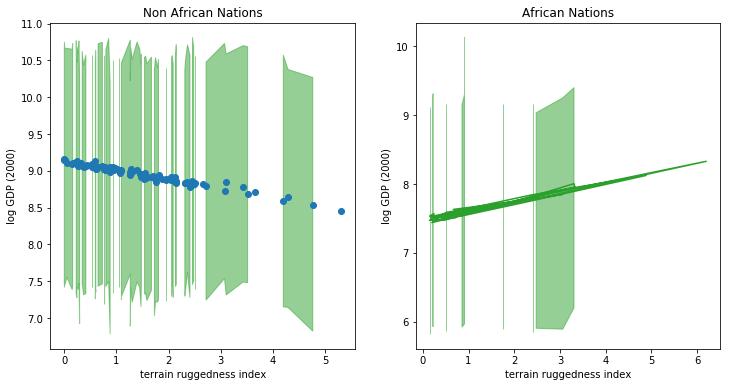

In [127]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
idx = np.argsort(non_african_nations["rugged"])
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["gdp_mean"], "C0o")
ax[0].fill_between(non_african_nations["rugged"].sort_values(), 
                   non_african_nations["gdp_perc_5"][idx], 
                   non_african_nations["gdp_perc_95"][idx], 
                   color="C2", alpha=0.5)
ax[0].set(xlabel="terrain ruggedness index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"], 
           african_nations["gdp_mean"], "C2")
ax[1].fill_between(african_nations["rugged"].sort_values(), 
                   african_nations["gdp_perc_5"][idx], 
                   african_nations["gdp_perc_95"][idx], 
                   color="C2", alpha=0.5)
ax[1].set(xlabel="terrain ruggedness index",
          ylabel="log GDP (2000)",
          title="African Nations")

In [123]:
non_african_nations

,cont_africa,rugged,gdp_mean,gdp_perc_5,gdp_perc_95
0,0.0,1.807,8.943638,7.249216,10.516403
1,0.0,4.761,8.533447,6.821489,10.269690
2,0.0,0.607,9.031301,7.352562,10.536132
3,0.0,2.088,8.907916,7.280717,10.450737
4,0.0,1.051,9.005611,7.419846,10.536044
6,0.0,1.960,8.878945,7.290058,10.470405
8,0.0,1.098,9.005069,7.466272,10.623141
11,0.0,1.073,8.972250,7.328052,10.768593
12,0.0,0.346,9.062443,7.535627,10.732167
13,0.0,2.665,8.823477,7.142576,10.377973
